In [16]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
import MeshCat as mc
import Distributions
import Random

using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using CSV
using DataFrames


  Activating project at `c:\Users\Daniel\Documents\Python-Projects\AiPEX-Projects\warmstarting_NLPs\JL_presolves`


In [17]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

In [18]:
# cartpole 
function dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    xdot = [qd;qdd]
    return xdot 

end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
     x_mid = 0.5(x1 + x2) + (dt/8) * (dynamics(params, x1, u) - dynamics(params, x2, u))
     res = x1 + (dt/6) * (dynamics(params, x1, u) + 4*dynamics(params, x_mid, u) + dynamics(params, x2, u)) - x2
     return res
end

hermite_simpson (generic function with 1 method)

In [19]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function cartpole_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    J = 0 

    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 0.5*(xi-xg)'*Q*(xi-xg) + 0.5*ui'*R*ui
    end
    
    # dont forget terminal cost 
    xN = Z[idx.x[N]]
    J += 0.5*(xN-xg)'*Qf*(xN-xg)
    return J 
end

function cartpole_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 

    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function cartpole_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    
    # TODO: return all of the equality constraints 

    
    return [Z[idx.x[1]] - xic; Z[idx.x[end]] - xg; cartpole_dynamics_constraints(params, Z)] 
end

function solve_cartpole_swingup(σ; verbose=true)
    
    # problem size 
    nx = 4 
    nu = 1 
    dt = 0.05
    tf = 2.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    # xic = [0, 0, 0, 0]
    xic = [σ[1], σ[2], 0, 0]
    xg = [0, pi, 0, 0]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 1.0, mp = 0.2, l = 0.5)
    
    # TODO: primal bounds 
    x_l = fill(-Inf, idx.nz)
    x_u = fill(Inf, idx.nz)
    
    for i = 1:(N-1)
        x_l[idx.u[i]] .= -10
        x_u[idx.u[i]] .= 10
    end

    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    # z0 = z0
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
#     diff_type = :finite
    
    # @show cartpole_equality_constraint(params, z0)
    # @show cartpole_dynamics_constraints(params, z0)
    # @show inequality_constraint(params, z0)
    # @show cartpole_cost(params, z0)
        
    Z, obj, solve_time_sec, term_status = fmincon(cartpole_cost,cartpole_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    # term_status = 0




    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, obj, solve_time_sec, term_status, t_vec, params 
end


    


solve_cartpole_swingup (generic function with 1 method)

## Solve cartpole for a single parameter sample

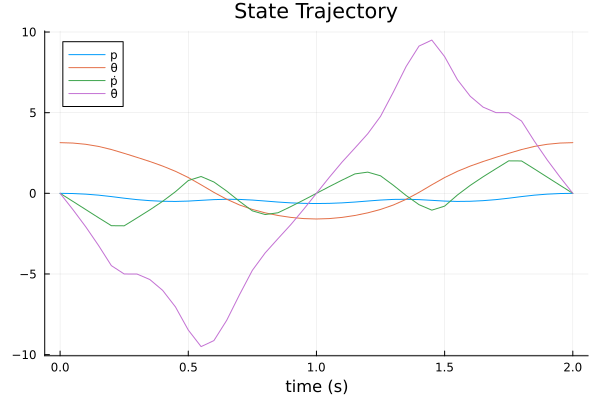

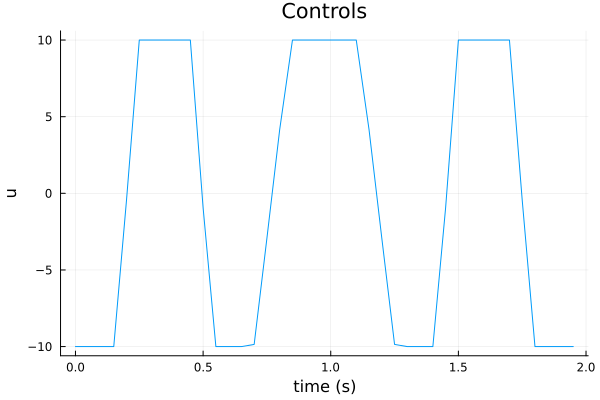

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    34272
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:      168
Total number of inequality constraints......

┌ Info: Listening on: 127.0.0.1:8700, thread id: 1
└ @ HTTP.Servers C:\Users\Daniel\.julia\packages\HTTP\sJD5V\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\Daniel\.julia\packages\MeshCat\0RCA3\src\visualizer.jl:64


ErrorException: The function body AST defined by this @generated function is not pure. This likely means it contains a closure, a comprehension or a generator.

In [23]:

σ = [0, pi, 0, 0]

X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ; verbose=true)

# --------------testing------------------

Xm = hcat(X...)
Um = hcat(U...)

# --------------plotting-----------------
display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))

display(animate_cartpole(X, 0.05))



## Solve the DIRCOL NLP for a parameter set

In [12]:
## Define upper and lower bounds of the parameters for the Paramaetric Optimal Control Problem
# using the xic of the cartpole
using Random, Distributions, CSV, DataFrames, ProgressMeter
Random.seed!(123)

N = 50 # number of samples
σ_lower = [-1.0, 0]
σ_upper = [1.0, 2*pi]

# Randomly sample the iid parameters uniformly from the given bounds
d = Product(Uniform.(σ_lower, σ_upper))
σ_samples = rand(d, N)
σ_samples = eachcol(σ_samples)

# Solve the NLP for the parameter sample set
df = DataFrame(params = Vector{Vector{Float64}}(), X=Vector{Vector{Vector{Float64}}}(), U=Vector{Vector{Vector{Float64}}}(), obj = Float64[], solve_time_sec = Float64[], term_status = MOI.TerminationStatusCode[])

p = Progress(N, 1)
i = 1
for σ in σ_samples
    next!(p)
    # z0 = 0.001*randn(idx.nz)
    X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ, verbose=false)

    # if i % 10 == 0
    #     println("Sample: ", i)
    #     println("------------------")
    #     println("σ: ", σ)
    #     println("Objective Value: ", obj)
    #     println("Termination Status Code: ", term_status)
    #     println("Solve Time: ", solve_time_sec, "s")
    #     println("")
    # end

    push!(df, [σ, X, U, obj, solve_time_sec, term_status])
    i += 1
end



Progress:  20%|█████████                                |  ETA: 0:00:53

Sample: 10
------------------
σ: [0.3289369574538574, 1.8558424829083464]
Objective Value: 579.3567587328713
Termination Status Code: LOCALLY_SOLVED
Solve Time: 0.7070000171661377s


Progress:  24%|██████████                               |  ETA: 0:00:49

Progress:  42%|██████████████████                       |  ETA: 0:00:33

Sample: 20
------------------
σ: [-0.8556385525971864, 5.744380715941141]
Objective Value: 1234.8189201279833
Termination Status Code: LOCALLY_INFEASIBLE
Solve Time: 1.4399998188018799s



Progress:  60%|█████████████████████████                |  ETA: 0:00:24

Sample: 30
------------------
σ: [0.7579538838754145, 2.6218734237593]
Objective Value: 755.2349858915537
Termination Status Code: LOCALLY_SOLVED
Solve Time: 0.875999927520752s



Progress:  82%|██████████████████████████████████       |  ETA: 0:00:12

Sample: 40
------------------
σ: [0.2775156760816275, 4.444580504830885]
Objective Value: 1301.1646003930089
Termination Status Code: LOCALLY_INFEASIBLE
Solve Time: 1.2800002098083496s



Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


Sample: 50
------------------
σ: [-0.7868134932131483, 5.026403741532868]
Objective Value: 1295.0411977779097
Termination Status Code: LOCALLY_INFEASIBLE
Solve Time: 1.372999906539917s



In [13]:

CSV.write("../data/presolves/cartpole_DIRCOL_1000_pi_wrap_fix.csv", df)

df

Row,params,X,U,obj,solve_time_sec,term_status
,Array…,Array…,Array…,Float64,Float64,Terminat…
1,"[0.0424276, 3.68702]","[[0.0424276, 3.36401, 1.3343e-13, -4.13204e-13], [0.0305589, 3.34618, -0.475212, -0.71751], [-0.00518509, 3.29138, -0.955873, -1.48714], [-0.0651933, 3.19576, -1.44627, -2.35874], [-0.149983, 3.05315, -1.94647, -3.37086], [-0.259834, 2.85621, -2.4454, -4.52809], [-0.393997, 2.59885, -2.91185, -5.77165], [-0.541889, 2.29192, -2.99259, -6.52192], [-0.67762, 1.96172, -2.43181, -6.76197], [-0.784287, 1.60815, -1.82365, -7.45827] … [-0.723382, 0.93674, 0.762677, 9.87304], [-0.665318, 1.39045, 1.54164, 8.36725], [-0.571054, 1.78275, 2.21331, 7.41306], [-0.445188, 2.14016, 2.81291, 6.96499], [-0.313006, 2.4587, 2.4556, 5.75849], [-0.201164, 2.71481, 2.00669, 4.48245], [-0.113088, 2.90742, 1.51208, 3.23326], [-0.0501441, 3.03969, 1.00532, 2.07466], [-0.01251, 3.11647, 0.50078, 1.00969], [-5.06005e-14, 3.14159, -3.17132e-14, 2.27827e-13]]","[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], [-10.0], [-3.21022], [10.0], [10.0], [10.0] … [6.1324], [10.0], [10.0], [10.0], [-10.0], [-10.0], [-10.0], [-10.0], [-10.0], [-10.0]]",1284.36,2.013,LOCALLY_INFEASIBLE
2,"[0.781757, 1.1995]","[[0.781757, 1.1995, 0.0, 0.0], [0.788533, 1.17171, 0.272277, -1.11308], [0.807768, 1.08908, 0.500511, -2.19502], [0.837164, 0.95372, 0.679895, -3.21961], [0.873725, 0.770391, 0.785936, -4.1034], [0.913105, 0.549328, 0.788331, -4.70913], [0.949845, 0.307568, 0.674686, -4.90963], [0.978798, 0.0659107, 0.474417, -4.69738], [0.997089, -0.157851, 0.250244, -4.20355], [1.00491, -0.35342, 0.0591405, -3.58466] … [-0.183943, 2.42925, -0.28113, 2.19526], [-0.190391, 2.53553, 0.0240413, 2.07754], [-0.182903, 2.6367, 0.276471, 1.98966], [-0.164128, 2.73385, 0.475599, 1.91529], [-0.136792, 2.82722, 0.618885, 1.83723], [-0.103845, 2.91604, 0.700046, 1.73253], [-0.0686927, 2.99815, 0.707028, 1.56702], [-0.0355613, 3.0692, 0.619124, 1.28776], [-0.0100467, 3.12142, 0.402183, 0.810913], [0.0, 3.14159, 0.0, 6.18656e-18]]","[[5.66962], [4.30878], [2.61307], [0.38158], [-2.08568], [-4.05346], [-4.82231], [-4.30825], [-3.01006], [-1.50288] … [8.4594], [7.23194], [5.99055], [4.74533], [3.46103], [2.06493], [0.443004], [-1.57659], [-4.25933], [-8.03091]]",489.919,0.992,LOCALLY_SOLVED
3,"[0.0513248, 2.45414]","[[0.0513248, 2.45414, 0.0, 0.0], [0.0408193, 2.42231, -0.419073, -1.27258], [0.0189762, 2.34077, -0.453264, -1.99589], [0.00334522, 2.23223, -0.1715, -2.36464], [0.00533211, 2.10634, 0.251533, -2.69657], [0.0286213, 1.95992, 0.68209, -3.18785], [0.0738494, 1.78464, 1.13138, -3.85447], [0.142345, 1.57113, 1.61607, -4.72234], [0.236424, 1.30838, 2.15895, -5.83227], [0.35419, 0.98687, 2.56357, -7.05553] … [-0.234151, 2.08124, -0.82809, 3.11014], [-0.264762, 2.22746, -0.397217, 2.76829], [-0.273886, 2.36101, 0.0327577, 2.60332], [-0.261384, 2.49077, 0.468846, 2.61785], [-0.226805, 2.62598, 0.916701, 2.82414], [-0.172457, 2.77132, 1.25939, 3.02191], [-0.108131, 2.91726, 1.31451, 2.84087], [-0.0501441, 3.03969, 1.00532, 2.07466], [-0.01251, 3.11647, 0.50078, 1.00969], [0.0, 3.14159, 0.0, -3.36526e-32]]","[[-8.14311], [0.0434656], [6.88853], [10.0], [10.0], [10.0], [10.0], [10.0], [4.9577], [-7.11959] … [10.0], [10.0], [10.0], [10.0], [10.0], [7.50422], [1.41775], [-6.00892], [-10.0], [-10.0]]",684.66,0.816,LOCALLY_SOLVED
4,"[-0.910364, 5.86443]","[[-0.910364, 5.86443, 2.05949e-13, -5.8868e-13], [-0.89927, 3.05613, 0.450851, 0.861304], [-0.889394, 3.07208, -0.0556614, -0.22054], [-0.904848, 3.03388, -0.562822, -1.31357], [-0.945716, 2.9397, -1.07204, -2.46674], [-1.01198, 2.7858, -1.57651, -3.70214], [-1.10292, 2.56857, -2.05341, -4.99007], [-1.21001, 2.29707, -2.21978, -5.87833], [-1.30783, 1.99878, -1.68949, -6.12032], [-1.37833, 1.6784, -1.12167, -6.76231] … [-0.726448, 0.934, 0.785251, 9.89781], [-0.667215, 1.38886, 1.56584, 8.38857], [-0.571704, 1.78218, 2.23893, 7.43297], [-0.445188, 2.14016, 2.81291, 6.96499], [-0.313006, 2.4587, 2.4556, 5.75849], [-0.201164, 2.71481

## Load in the Warmstarts and Solve for the Refined Trajectories

In [9]:
# using CSV

# df = DataFrame(CSV.File("data/warmstart_cartpole.csv"))
# Z_warmstart_str = df.Z_warmstart[1]
# @show Z_warmstart_str
# Z_warmstart_str = replace(Z_warmstart_str, r"\n" => "")
# Z_warmstart = eval(Meta.parse(Z_warmstart_str))
# # # Function to convert the string representation to a 2D array
# # function convert_to_2d_array(str::String)
# #     # Remove the brackets and newline characters
# #     clean_str = replace(str, r"[\[\]\n]" => "")
# #     # Split the string into individual numbers
# #     num_strs = split(clean_str)
# #     # Convert the numbers to Float64
# #     nums = parse.(Float64, num_strs)
# #     # Reshape the flat array into a 2D array
# #     num_rows = count(x -> x == '\n', str) + 1
# #     num_cols = length(nums) ÷ num_rows
# #     return reshape(nums, num_cols, num_rows)'
# # end

# # X_warmstart = convert_to_2d_array(X_warmstart_str)
# # X_warmstart = X_warmstart'
# # X_warmstart = [X_warmstart[:, i] for i in 1:size(X_warmstart, 2)]
# # @show size(X_warmstart[1])

In [10]:
# # Assuming you have a DataFrame named df

# for row in eachrow(df)
#     Z_warmstart_str = row.Z_warmstart
#     Z_warmstart_str = replace(Z_warmstart_str, r"\n" => "")
#     Z_warmstart = vec(eval(Meta.parse(Z_warmstart_str)))
#     # @show typeof(Z_warmstart)
#     param_str = row.params
#     σ = vec(eval(Meta.parse(param_str)))
#     # @show typeof(vec(param_str))

#     X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ, Z_warmstart; verbose=false)


# end